In [1]:
import sys , os
sys.path.append('../')

from dnn.bitwise_autoencoder import *
from dnn.bitwise_ss import *
from datasets.two_source_mixture import *
from datasets.sinusoidal_data import *
from datasets.quantized_data import *
from datasets.binary_data import *
from loss_and_metrics.bss_eval import *
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import soundfile as sf
import seaborn as sns
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Binary Neural Network

In [2]:
def evaluate_binary(model, binary_val, valset, max_samples=100):
    bss_metrics = BSSMetricsList()
    for i in range(len(binary_val)):
        if i >= max_samples:
            return bss_metrics
        sample = valset[i]
        mix = sample['mixture']
        target = sample['target']
        val_mag, val_phase = stft(mix)
        interference = sample['interference']
        bmag = torch.FloatTensor(binary_val[i]['bmag']).unsqueeze(0)
        model_in = flatten(bmag)
        premask = model(model_in)
        premask = unflatten(premask, bmag.size(0), bmag.size(2))
        mask = make_binary_mask(premask).squeeze(0)
        estimate = istft(val_mag * mask.numpy(), val_phase)
        sources = np.stack([target, interference], axis=0)
        metric = bss_eval_np(estimate, sources)
        bss_metrics.append(metric)
    return bss_metrics

def run_evaluation(model, dl):
    bss_metrics = BSSMetricsList()
    for batch in dl:
        metrics = evaluate(model, batch)
        bss_metrics.extend(metrics)
            
    sdr, sir, sar = bss_metrics.mean()
    print('Mean SDR %f' % sdr)
    print('Mean SIR %f' % sir)
    print('Mean SAR %f'% sar)
    return bss_metrics
    
def get_audio_output(model, binary_sample, raw_sample):
    mix = raw_sample['mixture']
    target = raw_sample['target']
    val_mag, val_phase = stft(mix)
    bmag = torch.FloatTensor(binary_sample['bmag']).unsqueeze(0)
    model_in = flatten(bmag)
    premask = model(model_in)
    premask = unflatten(premask, bmag.size(0), bmag.size(2))
    mask = make_binary_mask(premask).squeeze(0)
    estimate = istft(val_mag * mask.numpy(), val_phase)
    ipd.display(ipd.Audio(mix, rate=16000))
    ipd.display(ipd.Audio(estimate, rate=16000))
    ipd.display(ipd.Audio(target, rate=16000))
    
def visualize_mask(binary_sample, raw_sample, model=None):
    _, _, mask, ibm = evaluate(binary_sample, raw_sample, model)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.pcolormesh(ibm, cmap='binary')
    plt.subplot(122)
    plt.pcolormesh(mask, cmap='binary')
    
def visualize_input(binary_sample, num_bits=4):
    bmag, ibm = binary_sample['bmag'], binary_sample['ibm']
    qmag = np.zeros((bmag.shape[0] // num_bits, bmag.shape[1]))
    for i in range(bmag.shape[0] // num_bits):
        for j in range(num_bits):
            qmag[i] += 2**(num_bits - j - 1) * bmag[num_bits*i + j]
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.pcolormesh(qmag, cmap='binary')
    plt.subplot(122)
    plt.pcolormesh(ibm, cmap='binary')

Number of Training Examples:  2940
Number of Validation Examples:  540


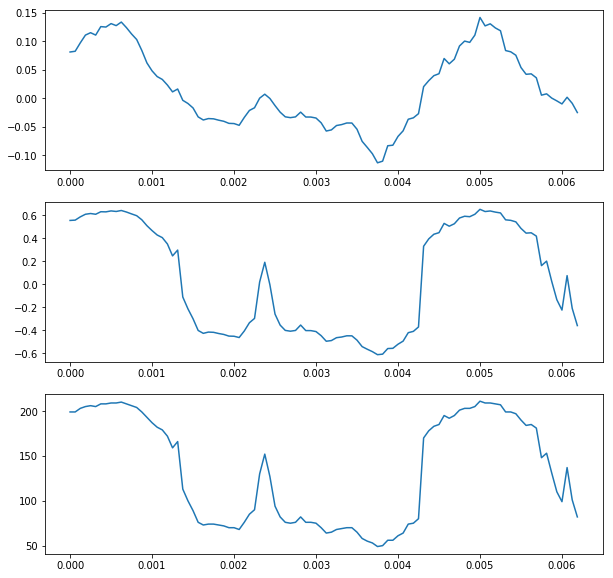

In [3]:
# Configuration
toy = False
sample_rate = 16000
num_bits = 8
quantizer = Quantizer(min=-1, delta=2/(2**num_bits), num_bits=num_bits)
trainset, valset = make_mixture_set(toy=toy)
print('Number of Training Examples: ', len(trainset))
print('Number of Validation Examples: ', len(valset))
sample = trainset[0]['mixture'][8000:8100]
time = np.arange(len(sample))/16000
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(time, sample)
plt.subplot(3, 1, 2)
mu_sample = mu_law(torch.FloatTensor(sample), 256)
plt.plot(time, mu_sample.numpy())
plt.subplot(3, 1, 3)
qsample = quantizer(torch.FloatTensor(sample))
plt.plot(time, qsample.numpy())

In [4]:
binary_train = BinaryDataset('/media/data/binary_audio/train')
binary_val = BinaryDataset('/media/data/binary_audio/val')
print('Number of Binary Training Examples: ', len(binary_train))
print('Number of Binary Validation Examples: ', len(binary_val))

Number of Binary Training Examples:  2940
Number of Binary Validation Examples:  540


(513, 91)


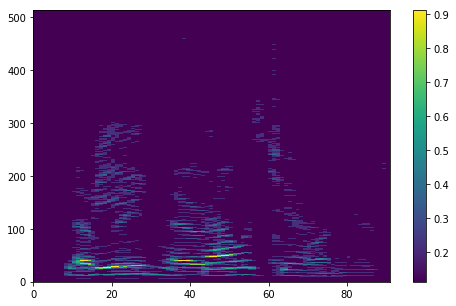

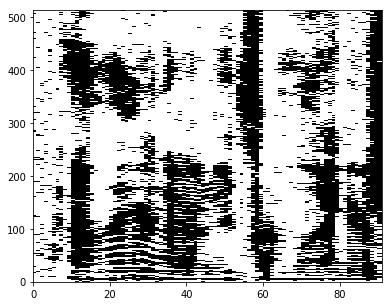

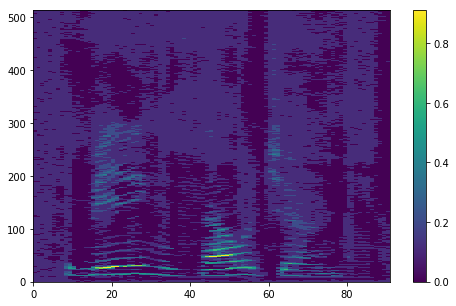

In [5]:
sample = binary_train[0]
quantizer = Quantizer(min=-1, delta=2/2**(4), num_bits=4, use_mu=True)
disperser = Disperser(4)
bmag = sample['bmag']
ibm = sample['ibm']

mix = accumulate(bmag, quantizer, disperser)
print(mix.shape)
plt.figure(figsize=(8, 5))
plt.pcolormesh(np.sqrt(mix))
plt.colorbar()
plt.figure(figsize=(6.25, 5))
plt.pcolormesh(ibm, cmap='gray')
targ = ibm * mix
plt.figure(figsize=(8, 5))
plt.pcolormesh(np.sqrt(targ))
plt.colorbar()

In [6]:
# Load Dataset
sample = trainset[0]
targ = torch.FloatTensor(sample['target'])
quantized_targ = quantizer(targ)
reconstructed_targ = quantizer.inverse(quantized_targ)
ipd.display(ipd.Audio(targ, rate=16000))
ipd.display(ipd.Audio(reconstructed_targ, rate=16000))

## Bitwise Neural Network Evaluation

In [8]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/real_ss.model'))
mlp.eval()
bss_metrics = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

# Evaluate real source separation network
mlp.noisy()
bss_metrics = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

RuntimeError: Error(s) in loading state_dict for BitwiseMLP:
	Missing key(s) in state_dict: "gamma", "filter_list.0.weight", "filter_list.0.gamma", "filter_list.0.beta", "filter_list.1.weight", "filter_list.1.gamma", "filter_list.1.beta", "filter_list.2.weight", "filter_list.2.gamma", "filter_list.2.beta". 
	Unexpected key(s) in state_dict: "linear_list.0.weight", "linear_list.0.beta", "linear_list.1.weight", "linear_list.1.beta", "linear_list.2.weight", "linear_list.2.beta". 

In [8]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/real_ug_sq.model'))
mlp.eval()
bss_metrics = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])
real_net_weights0 = mlp.filter_list[0].get_effective_weight()
real_net_weights1 = mlp.filter_list[1].get_effective_weight()
real_net_weights2 = mlp.filter_list[2].get_effective_weight()

# Evaluate real source separation network
mlp.noisy()
bss_metrics = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])
binary_net_weights0 = mlp.filter_list[0].get_effective_weight()
binary_net_weights1 = mlp.filter_list[1].get_effective_weight()
binary_net_weights2 = mlp.filter_list[2].get_effective_weight()

Mean SDR:  7.380762959627697
Mean SIR:  18.321913754053377
Mean SAR:  8.168278869273852


Mean SDR:  6.374300172339778
Mean SIR:  15.305608400468422
Mean SAR:  7.464366224384371


In [37]:
def cossine_sim(real_weight, binary_weight):
    product= torch.dot(real_weight, binary_weight)
    return product / (torch.norm(real_weight, 2) * torch.norm(binary_weight, 2))

print(torch.max(torch.abs(real_net_weights0 - binary_net_weights0), 1))
print(real_net_weights0[0, 1967], binary_net_weights0[0, 1967])
print(mlp.filter_list[0].weight[0, 1967], mlp.filter_list[0].gate[0, 1967])
print(torch.tanh(mlp.filter_list[0].gamma*100 * mlp.filter_list[0].weight[0, 1967]))
print(torch.sigmoid(torch.tanh(mlp.filter_list[0].gamma * mlp.filter_list[0].gate[0, 1967])))

(tensor([0.9709, 0.9210, 0.8411,  ..., 0.9389, 0.7566, 0.9487],
       grad_fn=<MaxBackward0>), tensor([1967,  843, 1858,  ..., 1490, 1483, 1683]))
tensor(-0.0291, grad_fn=<SelectBackward>) tensor(-1., grad_fn=<SelectBackward>)
tensor(-0.0000, grad_fn=<SelectBackward>) tensor(0.0380, grad_fn=<SelectBackward>)
tensor(-0.9941, grad_fn=<TanhBackward>)
tensor(0.7311, grad_fn=<SigmoidBackward>)


In [ ]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/real_ss_gate.model'))
mlp.eval()
bss_metrics = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

In [9]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2052, 2052], residual=True)
mlp.load_state_dict(torch.load('../models/real_ss_residual.model'))
mlp.eval()
bss_metrics = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  8.321952252739791
Mean SIR:  17.741391864843315
Mean SAR:  9.193744410398745


In [52]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bitwise_ss.model'))
mlp.noisy()
mlp.eval()
bss_metrics_sp0 = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics_sp0.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.559482525677526
Mean SIR:  15.900702328197196
Mean SAR:  8.722784025912656


In [ ]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2052, 2052], residual=True)
mlp.load_state_dict(torch.load('../models/bitwise_ss_residual.model'))
mlp.noisy()
mlp.eval()
bss_metrics_sp0 = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics_sp0.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  1.9828266502093446
Mean SIR:  3.3203874940011016
Mean SAR:  9.847154215160408


In [19]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bitwise_ss_sp50.model'))
mlp.noisy()
mlp.eval()
bss_metrics_sp50 = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics_sp50.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.779755462878617
Mean SIR:  17.19875291691862
Mean SAR:  8.71060168531926


In [24]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048])
mlp.load_state_dict(torch.load('../models/bitwise_ss_sp33.model'))
mlp.noisy()
mlp.eval()
bss_metrics_sp33 = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics_sp33.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.642495911959371
Mean SIR:  17.758318853754893
Mean SAR:  8.451950195929806


In [53]:
# Evaluate real source separation network
mlp = BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], use_gate=True)
mlp.load_state_dict(torch.load('../models/bitwise_ss_gate.model'))
mlp.noisy()
mlp.eval()
bss_metrics_v2 = evaluate_binary(mlp, binary_val, valset)
sdr, sir, sar = bss_metrics_v2.mean()
print('Mean SDR: ', sdr)
print('Mean SIR: ', sir)
print('Mean SAR: ', sar)
get_audio_output(mlp, binary_val[0], valset[0])

Mean SDR:  7.860932209180636
Mean SIR:  18.483339864788206
Mean SAR:  8.606731595995246


In [22]:
total_pass = torch.sum((mlp.linear_list[0].gate > 0).float()) + \
      torch.sum((mlp.linear_list[1].gate > 0).float()) + \
      torch.sum((mlp.linear_list[2].gate > 0).float())
total_units = mlp.linear_list[0].gate.view(-1).size(0) + \
     mlp.linear_list[1].gate.view(-1).size(0) + \
     mlp.linear_list[2].gate.view(-1).size(0)
total_pass / total_units

tensor(0.3757)

In [25]:
data_length = len(valset)
data_dict = {'sdr': bss_metrics_sp0.sdrs + bss_metrics_sp33.sdrs + bss_metrics_sp50.sdrs + bss_metrics_v2.sdrs,
             'sir': bss_metrics_sp0.sirs + bss_metrics_sp33.sirs + bss_metrics_sp50.sirs + bss_metrics_v2.sirs,
             'sar': bss_metrics_sp0.sars + bss_metrics_sp33.sars + bss_metrics_sp50.sars + bss_metrics_v2.sars,
             'model type': ['sp0' for _ in range(data_length)] + \
             ['sp33' for _ in range(data_length)] + \
             ['sp50' for _ in range(data_length)] + \
             ['filter gate' for _ in range(data_length)]
            }
df = pd.DataFrame(data_dict)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


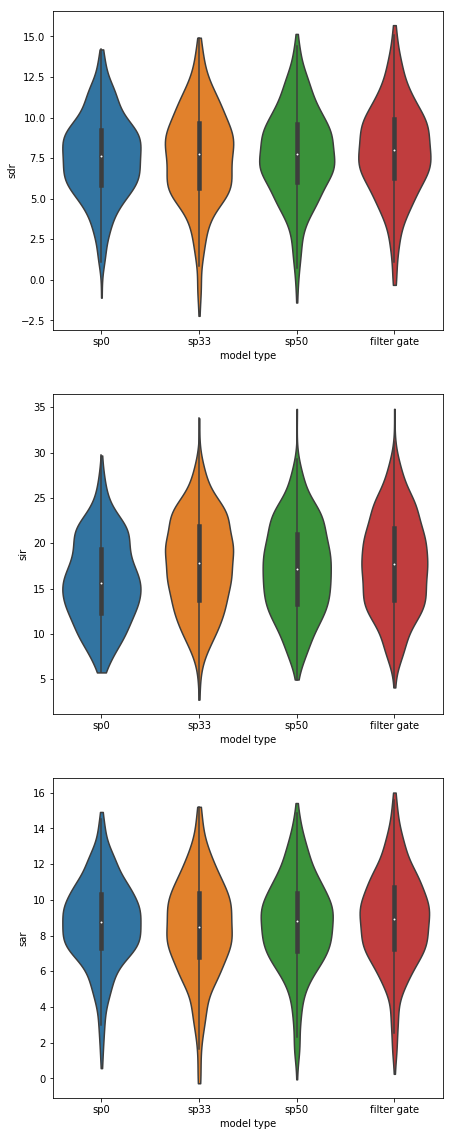

In [26]:
plt.figure(figsize=(7, 20))
plt.subplot(3, 1, 1)
sns.violinplot(x='model type', y='sdr', data=df, cut=0)
plt.subplot(3, 1, 2)
sns.violinplot(x='model type', y='sir', data=df, cut=0)
plt.subplot(3, 1, 3)
sns.violinplot(x='model type', y='sar', data=df, cut=0)

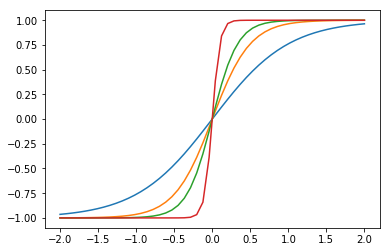

In [34]:
x = np.linspace(-2, 2)
plt.plot(x, np.tanh(x))
plt.plot(x, np.tanh(2*x))
plt.plot(x, np.tanh(3*x))
plt.plot(x, np.tanh(10*x))